#Importation des librairies

In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import random
import gc
import math

from imutils import face_utils
import imutils
import dlib

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from PIL import Image
import io

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
import scipy.misc
import dlib
import cv2
from sklearn import preprocessing
from imutils import face_utils
import numpy as np
from keras.optimizers import SGD

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from numpy.random import seed
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from zipfile import ZipFile
file_name1 = "/content/drive/My Drive/dataset/train_test_landmarks.zip" 
file_name4 = "/content/drive/MyDrive/dataset/train_test_faceImages.zip"

In [5]:
with ZipFile(file_name1, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [6]:
with ZipFile(file_name4, 'r') as zip:
  zip.extractall()
  print('Done')

Done


# **Fonctions pour utiliser la webcam dans Google Colab**

In [7]:
def VideoCapture():
  js = Javascript('''
    async function create(){
      div = document.createElement('div');
      document.body.appendChild(div);

      video = document.createElement('video');
      video.setAttribute('playsinline', '');

      div.appendChild(video);

      stream = await navigator.mediaDevices.getUserMedia({video: {facingMode: "environment"}});
      video.srcObject = stream;

      await video.play();

      canvas =  document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);

      div_out = document.createElement('div');
      document.body.appendChild(div_out);
      img = document.createElement('img');
      div_out.appendChild(img);
    }

    async function capture(){
        return await new Promise(function(resolve, reject){
            pendingResolve = resolve;
            canvas.getContext('2d').drawImage(video, 0, 0);
            result = canvas.toDataURL('image/jpeg', 0.8);
            pendingResolve(result);
        })
    }

    function showimg(imgb64){
        img.src = "data:image/jpg;base64," + imgb64;
    }

  ''')
  display(js)

def byte2image(byte):
  jpeg = b64decode(byte.split(',')[1])
  im = Image.open(io.BytesIO(jpeg))
  return np.array(im)

def image2byte(image):
  image = Image.fromarray(image)
  buffer = io.BytesIO()
  image.save(buffer, 'jpeg')
  buffer.seek(0)
  x = b64encode(buffer.read()).decode('utf-8')
  return x

# **Question 1 :  Emotion recognition system**


**1-1 Entrainement et évaluation du premier modèle**

Training set size:  741
Test set size:  365
Epoch 1/300
12/12 [==============================] - 0s 17ms/step - loss: 2.0921 - accuracy: 0.3441 - val_loss: 1.6014 - val_accuracy: 0.5836
Epoch 2/300
12/12 [==============================] - 0s 6ms/step - loss: 1.6024 - accuracy: 0.6005 - val_loss: 1.3275 - val_accuracy: 0.5973
Epoch 3/300
12/12 [==============================] - 0s 6ms/step - loss: 1.3816 - accuracy: 0.5547 - val_loss: 1.2615 - val_accuracy: 0.6219
Epoch 4/300
12/12 [==============================] - 0s 6ms/step - loss: 1.2872 - accuracy: 0.6113 - val_loss: 1.1617 - val_accuracy: 0.6603
Epoch 5/300
12/12 [==============================] - 0s 6ms/step - loss: 1.2090 - accuracy: 0.6208 - val_loss: 1.1176 - val_accuracy: 0.7151
Epoch 6/300
12/12 [==============================] - 0s 5ms/step - loss: 1.1549 - accuracy: 0.6653 - val_loss: 1.0532 - val_accuracy: 0.7041
Epoch 7/300
12/12 [==============================] - 0s 6ms/step - loss: 1.1134 - accuracy: 0.6518 - val_loss

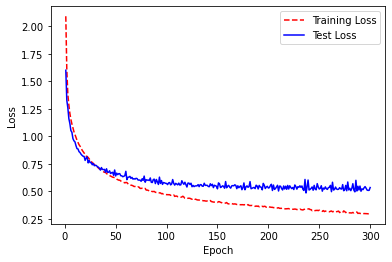

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


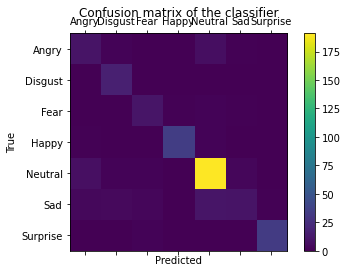

12/12 [==============================] - 0s 2ms/step - loss: 0.5354 - accuracy: 0.8411

accuracy: 84.11%


In [8]:
num_classes = 7 #'Angry','Disgust', 'Fear', 'Happy', 'Neutral', Sad', 'Surprise'
batch_size = 64
epochs = 300
fit = True
seed(8)

# --------------------------------------------------------------------
# Training and test data  
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

print ("Training set size: ", str(len(x_train)))
print ("Test set size: ", str(len(x_test)))
# --------------------------------------------------------------------
# Construct the NN structure
model = Sequential()
#1st layer
model.add(Dense(512, input_shape=(4624,)))
model.add(Dense(512))
model.add(Dense(512))
model.add(Dense(512))
model.add(Dense(512))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
opt = SGD(lr=0.0001, decay=1e-6, momentum=0.9)
# opt = keras.optimizers.Adam(lr=0.00001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit(x_train, # Features
                      y_train, # Target
                      epochs=epochs, # Number of epochs
                      verbose=1, # No output
                      batch_size=batch_size, # Number of observations per batch
                      validation_data=(x_test, y_test)) # Data for evaluation

# --------------------------------------------------------------------
# Visualize the training and test loss through epochs

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

y_pred = model.predict_classes(x_test)
y_true = [0] * len(y_pred)

for i in range(0, len(y_test)):
	max_index = np.argmax(y_test[i])
	y_true[i] = max_index

# --------------------------------------------------------------------
# Draw the confusion matrix 
cm = confusion_matrix(y_pred, y_true, labels=range(num_classes))

labels = ['Angry' , 'Disgust' , 'Fear' , 'Happy'  , 'Neutral' ,  'Sad' , 'Surprise']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# --------------------------------------------------------------------
# Evaluate the model on the test set
scores = model.evaluate(x_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# --------------------------------------------------------------------
# Save the model and the weights 
#model_json = model.to_json()
#with open("./model/model.json", "w") as json_file:
#    json_file.write(model_json)
#model.save_weights("./model/model.h5")
#print("Saved model to disk")

**1-2 Activation de la webcam et reconnaissance faciale + émotion** 

In [ ]:
# Lancement de la webcam
VideoCapture()
eval_js('create()')
# opencv initialization
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/dataset/haarcascade_frontalface_default.xml')

emotions = ('Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise')
# initialize dlib's face detector and create a predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/drive/MyDrive/dataset/shape_predictor_68_face_landmarks.dat")

def euclidean(a, b):
  dist = math.sqrt(math.pow((b[0] - a[0]), 2) + math.pow((b[1] - a[1]), 2))
  return dist

# calculates distances between all 68 element
def euclidean_all(a):
  distances = ""
  for i in range(0, len(a)):
    for j in range(0, len(a)):
      dist = euclidean(a[i], a[j])
      dist = "%.2f" % dist;
      distances = distances + " " + str(dist)
  return distances

while True:
  byte = eval_js('capture()')
  img = byte2image(byte)
  #print(img.shape)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)
  
  for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)  # draw rectangle to main image
    detected_face = img[int(y):int(y + h), int(x):int(x + w)]  # crop detected face

    # resize the image, and convert it to grayscale
    image = imutils.resize(detected_face, width=200, height=200)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # detect faces in the grayscale image
    rects = detector(gray, 1)
    # loop over the face detections
    for (i, rect) in enumerate(rects):
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        distances = euclidean_all(shape)

    distances = distances.strip() 
    val = distances.split(" ")
    val = np.array(val)
    val = val.astype(np.float)
    val = val.reshape(1, len(val))

    predictions = model.predict(val, batch_size=64)  # store probabilities of 6 expressions
    # find max indexed array ( 'Angry' , 'Disgust' , 'Fear' , 'Happy'  , 'Neutral' ,  'Sad' , 'Surprise')
    maxindex = int(np.argmax(predictions))
    emotion = emotions[maxindex]
        
    # write emotion text above rectangle
    cv2.putText(img, emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
  
  eval_js('showimg("{}")'.format(image2byte(img)))

En lançant le code dernier, on voit bien que ça fonctionne et le modèle permet de détecter les émotions avec quelques erreurs parfois

# **Question 2 : Utilisation du CNN** 

**2.1 Entrainement du second modèle CNN**

Training set size:  19357
Test set size:  2151
Epoch 1/50
303/303 [==============================] - 4s 15ms/step - loss: 1.8124 - accuracy: 0.2702 - val_loss: 1.7634 - val_accuracy: 0.2775
Epoch 2/50
303/303 [==============================] - 4s 14ms/step - loss: 1.6198 - accuracy: 0.3851 - val_loss: 1.4684 - val_accuracy: 0.4635
Epoch 3/50
303/303 [==============================] - 4s 13ms/step - loss: 1.4878 - accuracy: 0.4422 - val_loss: 1.3831 - val_accuracy: 0.4947
Epoch 4/50
303/303 [==============================] - 4s 14ms/step - loss: 1.4125 - accuracy: 0.4753 - val_loss: 1.3098 - val_accuracy: 0.5160
Epoch 5/50
303/303 [==============================] - 4s 14ms/step - loss: 1.3437 - accuracy: 0.5014 - val_loss: 1.2609 - val_accuracy: 0.5397
Epoch 6/50
303/303 [==============================] - 4s 14ms/step - loss: 1.2948 - accuracy: 0.5206 - val_loss: 1.2112 - val_accuracy: 0.5579
Epoch 7/50
303/303 [==============================] - 4s 14ms/step - loss: 1.2476 - accuracy: 0

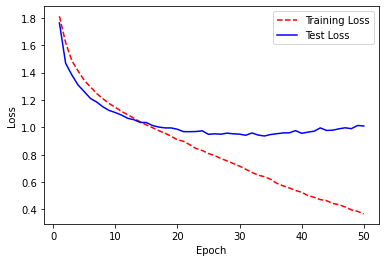

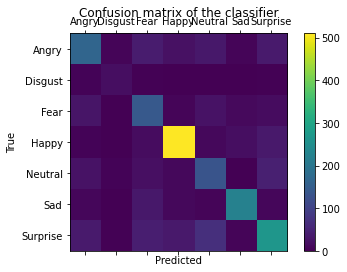

68/68 [==============================] - 0s 3ms/step - loss: 1.0100 - accuracy: 0.6806

accuracy: 68.06%


In [10]:
num_classes = 7 #'Angry','Disgust', 'Fear', 'Happy', 'Neutral', Sad', 'Surprise'
batch_size = 64
epochs = 50
fit = True
seed(8)
nval = 2151
ntrain = 19357

# --------------------------------------------------------------------
# Training and test data  
x_train = np.load('images_train.npy')
y_train = np.load('./labels_train.npy')
x_test = np.load('./images_test.npy')
y_test = np.load('./labels_test.npy')

print ("Training set size: ", str(len(x_train)))
print ("Test set size: ", str(len(x_test)))

# --------------------------------------------------------------------
# Construct the NN structure
model = Sequential()
#1st layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

# compile the model
opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit(x_train, # Features
                      y_train, # Target
                      epochs=epochs, # Number of epochs
                      verbose=1, # No output
                      batch_size=batch_size, # Number of observations per batch
                      validation_data=(x_test, y_test)) # Data for evaluation

# --------------------------------------------------------------------
# Visualize the training and test loss through epochs

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

y_pred = model.predict_classes(x_test)
y_true = [0] * len(y_pred)

for i in range(0, len(y_test)):
	max_index = np.argmax(y_test[i])
	y_true[i] = max_index

# --------------------------------------------------------------------
# Draw the confusion matrix 
cm = confusion_matrix(y_pred, y_true, labels=range(num_classes))

labels = ['Angry' , 'Disgust' , 'Fear' , 'Happy'  , 'Neutral' ,  'Sad' , 'Surprise']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# --------------------------------------------------------------------
# Evaluate the model on the test set
scores = model.evaluate(x_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# --------------------------------------------------------------------
# Save the model and the weights 
#model_json = model.to_json()
#with open("./model/model.json", "w") as json_file:
#    json_file.write(model_json)
#model.save_weights("./model/model.h5")
#print("Saved model to disk")

 **2-2 Reconnaissance des émotions en temps réel avec la webcam** (Q2)

In [ ]:
# Lancement de la webcam
VideoCapture()
eval_js('create()')
# opencv initialization
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/dataset/haarcascade_frontalface_default.xml')

emotions = ('Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise')
# initialize dlib's face detector and create a predictor
detector = dlib.get_frontal_face_detector()

while True:
  byte = eval_js('capture()')
  img = byte2image(byte)
  #print(img.shape)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)
  
  for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)  # draw rectangle to main image
    detected_face = gray[y:y + h, x:x + w]  # crop detected face
    cropped_img = np.expand_dims(np.expand_dims(cv2.resize(detected_face, (48, 48)), -1), 0)

    predictions = model.predict(cropped_img)  # store probabilities of 6 expressions
    # find max indexed array ( 'Angry' , 'Disgust' , 'Fear' , 'Happy'  , 'Neutral' ,  'Sad' , 'Surprise')
    maxindex = int(np.argmax(predictions))
    emotion = emotions[maxindex]
        
    # write emotion text above rectangle
    cv2.putText(img, emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
  
  eval_js('showimg("{}")'.format(image2byte(img)))